C:\Users\roksa\AppData\Local\Temp\ipykernel_17196\436716509.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').dropna()


                     temperature_2m  dew_point_2m  relative_humidity_2m  \
time                                                                      
2024-06-01 00:00:00            22.3          17.2                    73   
2024-06-01 01:00:00            22.1          17.1                    73   
2024-06-01 02:00:00            22.1          17.2                    74   
2024-06-01 03:00:00            21.9          17.3                    75   
2024-06-01 04:00:00            21.7          17.6                    78   

                     pressure_msl  wind_speed_10m  wind_direction_10m  \
time                                                                    
2024-06-01 00:00:00        1017.6            10.3                 216   
2024-06-01 01:00:00        1017.3             8.8                 215   
2024-06-01 02:00:00        1017.1             6.9                 231   
2024-06-01 03:00:00        1017.2             5.8                 248   
2024-06-01 04:00:00        1017.0   

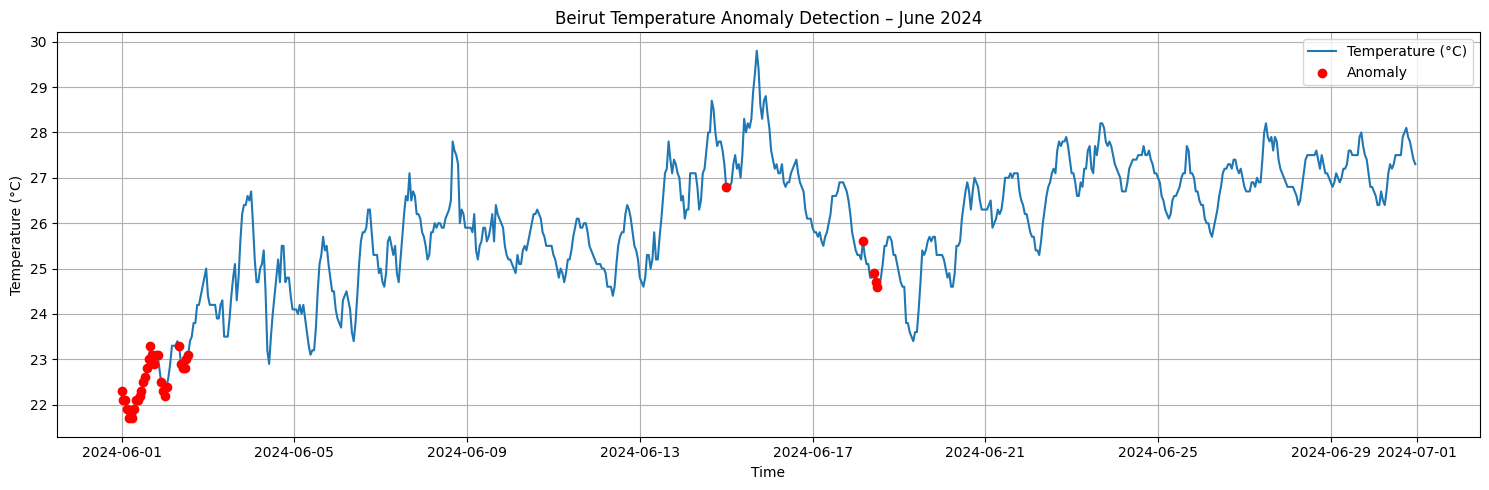

In [1]:
import requests
import pandas as pd

url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 33.8938,
    "longitude": 35.5018,
    "start_date": "2024-06-01",
    "end_date": "2024-06-30",
    "hourly": "temperature_2m,dew_point_2m,relative_humidity_2m,pressure_msl,wind_speed_10m,wind_direction_10m,shortwave_radiation",
    "timezone": "auto"
}

response = requests.get(url, params=params)
data = response.json()


df = pd.DataFrame(data['hourly'])
df.to_csv("beirut_weather_june2024.csv", index=False)

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest


df = pd.read_csv("beirut_weather_june2024.csv")

df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)


df = df.fillna(method='ffill').dropna()


features = [
    'temperature_2m', 'dew_point_2m', 'relative_humidity_2m',
    'pressure_msl', 'wind_speed_10m', 'wind_direction_10m', 'shortwave_radiation'
]


scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])


iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = iso_forest.fit_predict(scaled_data)


anomalies = df[df['anomaly'] == -1]
print(anomalies.head())

anomalies.to_csv("beirut_anomalies_detected.csv")
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(df.index, df['temperature_2m'], label='Temperature (°C)')
plt.scatter(anomalies.index, anomalies['temperature_2m'], color='red', label='Anomaly', zorder=3)
plt.title("Beirut Temperature Anomaly Detection – June 2024")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
import joblib

# Save the scaler
joblib.dump(scaler, "minmax_scaler.joblib")

# Save the IsolationForest model
joblib.dump(iso_forest, "isolation_forest_model.joblib")

['isolation_forest_model.joblib']